## Q1: Fragment length frequency + rescaling:
a) Fragment length frequency
We are given a file with each line indicating where a DNA fragment has mapped on the chromosome. Our goal is to count individual fragment lengths, and then normalize it by the total count of all fragment lengths. Once we have the normalized count, we will plot that using plotting packages in python. X-axis will be fragment length (unit - base pairs) and Y-axis-> Normalized frequencies. Fragment length can be simply calculated by subtracting 2nd column from the 3rd.

b) Rescaling
Often, we will receive two sets of data with different empirical distribution. The goal is to rescale one (query) to the other (reference). We are given a reference distribution (reference.hist) and a query bed file (query.bed.gz). We have to rescale (subsample the data) so that when we draw the normalized frequency, it should almost match the reference


### Part 1: Load Libraries & Define Helper Function

Before processing data, import all Python packages needed.  

- **numpy**: for numerical operations (not strictly required here but good practice).  
- **random**: for random sampling during rescaling.  
- **gzip**: to read gzipped BED files.  
- **matplotlib.pyplot**: for plotting distributions.  
- **collections.Counter**: to tally fragment lengths efficiently.


In [1]:
import numpy as np
import random
import gzip
import matplotlib.pyplot as plt
from collections import Counter


#### Function: `import_bed_file`

This function reads a gzipped BED file line by line, skips blank/commented lines,  
parses the 2nd and 3rd columns (start and end coordinates),  
computes each fragment’s length (`end - start`),  
and returns both:  
1. A list of all fragment lengths.  
2. A `Counter` object with counts for each unique fragment length.


In [2]:
def import_bed_file(bed_path):
    """
    Load a gzipped BED file and extract fragment lengths.

    Parameters:
        bed_path (str): Path to the gzipped BED file.

    Returns:
        tuple:
          - fragment_lengths (list[int]): All fragment lengths.
          - length_counts (Counter): Counts for each fragment length.
    """
    fragment_lengths = []
    with gzip.open(bed_path, 'rt') as f:
        for line in f:
            # Skip header/comments or empty lines
            if not line.strip() or line.startswith('#'):
                continue
            fields = line.strip().split('\t')
            start = int(fields[1])
            end   = int(fields[2])
            fragment_lengths.append(end - start)
    # Tally how many times each length appears
    length_counts = Counter(fragment_lengths)
    return fragment_lengths, length_counts


#### Load & Inspect Query Data

We now call `import_bed_file` on `query.bed.gz`  
and print the total number of fragments loaded.


In [3]:
fragment_lengths, length_freq = import_bed_file('query.bed.gz')
total_fragments = sum(length_freq.values())
print(f"Loaded {total_fragments:,} fragments from query.bed.gz")

Loaded 13,835,737 fragments from query.bed.gz


#### Function: `normalize_counts`

Normalization converts raw counts into relative frequencies:

$$
\text{normalized}[l] = \frac{\text{count}[l]}{\sum_{l} \text{count}[l]}
$$

This ensures the frequencies sum to 1, making distributions directly comparable.


In [4]:
def normalize_counts(counts):
    """
    Convert raw counts into relative frequencies.

    Parameters:
        counts (Counter): Raw counts of each fragment length.

    Returns:
        dict[int, float]: Normalized frequency for each fragment length.
    """
    total = sum(counts.values())
    return {length: freq / total for length, freq in counts.items()}

normalized_freq = normalize_counts(length_freq)


#### Plot: Fragment Length Distribution (Query)

We sort fragment lengths in ascending order, extract their normalized frequencies,  
and plot the resulting curve.  
- **X-axis**: fragment length (bp)  
- **Y-axis**: normalized frequency (arbitrary units)  
- The legend shows the total count for reference.


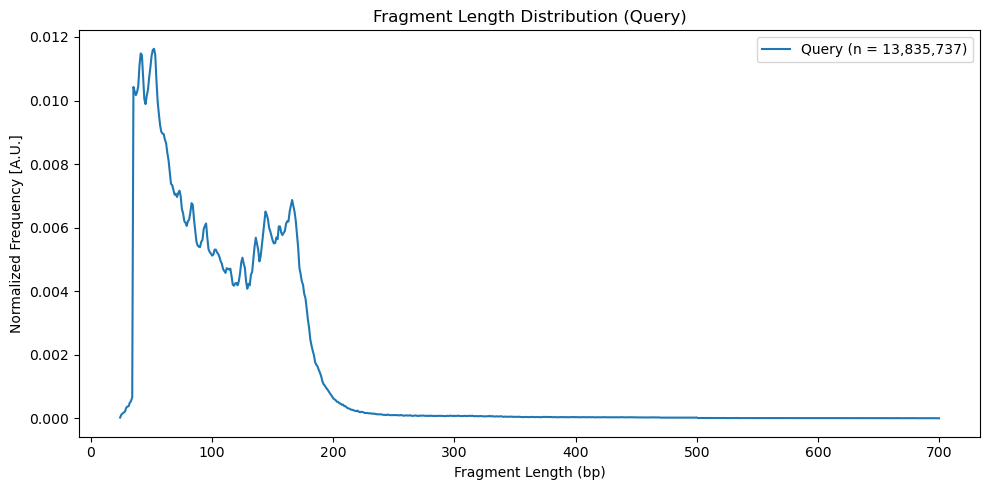

In [5]:
# Prepare sorted data
sorted_lengths = sorted(normalized_freq.keys())
sorted_freqs   = [normalized_freq[l] for l in sorted_lengths]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(sorted_lengths, sorted_freqs,
         label=f'Query (n = {total_fragments:,})',
         linewidth=1.5)
plt.xlabel("Fragment Length (bp)")
plt.ylabel("Normalized Frequency [A.U.]")
plt.title("Fragment Length Distribution (Query)")
plt.legend()
plt.tight_layout()
plt.show()


### Part 2: Rescaling to Reference Distribution

Now we want to *subsample* the query fragments so that its normalized distribution  
*matches* a supplied reference histogram (`reference.hist`).  
This involves:

1. Loading the reference histogram.  
2. Plotting query vs. reference for comparison.  
3. Computing how many fragments of each length we *should* keep.  
4. Randomly sampling from the query fragments accordingly.  
5. Plotting the rescaled distribution alongside the reference.


#### Function: `import_reference_histogram`

Reads a two-column text file where each line has:

- <fragment_length> \t <normalized_frequency>
- Returns a dict mapping `int(fragment_length)` → `float(frequency)`.


In [6]:
def import_reference_histogram(ref_path):
    """
    Load reference histogram from a text file.

    Parameters:
        ref_path (str): Path to the reference histogram file.

    Returns:
        dict[int, float]: Mapping from fragment length to reference frequency.
    """
    ref_freq = {}
    with open(ref_path) as f:
        for line in f:
            if not line.strip():
                continue
            length_str, freq_str = line.strip().split('\t')
            ref_freq[int(length_str)] = float(freq_str)
    return ref_freq

ref_freq_dict = import_reference_histogram('reference.hist')


#### Plot: Query vs. Reference (Before Rescaling)

Overlay the normalized query distribution and the reference distribution  
to visualize their differences.


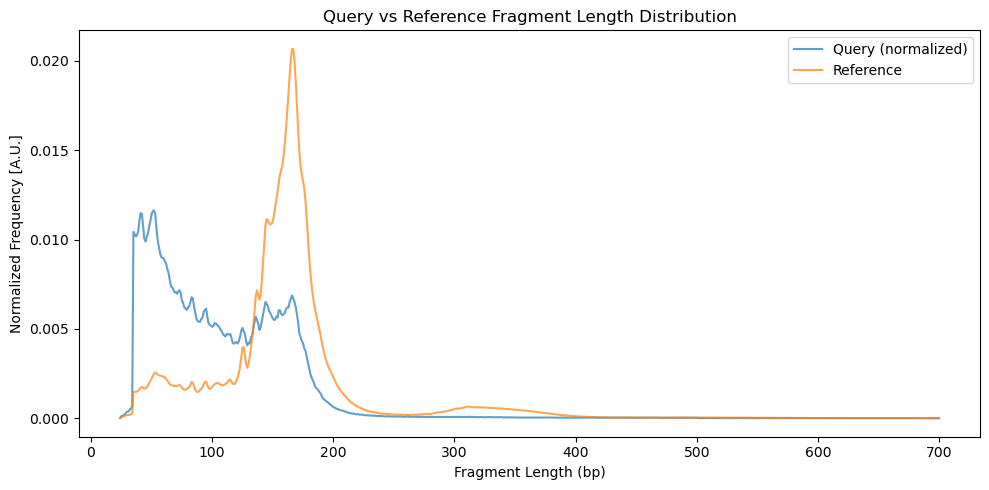

In [7]:
# Prepare reference data
ref_lengths = sorted(ref_freq_dict.keys())
ref_freqs   = [ref_freq_dict[l] for l in ref_lengths]

# Plot both distributions
plt.figure(figsize=(10, 5))
plt.plot(sorted_lengths, sorted_freqs, label='Query (normalized)', alpha=0.7)
plt.plot(ref_lengths,   ref_freqs,   label='Reference',         alpha=0.7)
plt.xlabel("Fragment Length (bp)")
plt.ylabel("Normalized Frequency [A.U.]")
plt.title("Query vs Reference Fragment Length Distribution")
plt.legend()
plt.tight_layout()
plt.show()


#### Subsampling Logic

To match the reference, we:

1. **Group** all query fragments by their length into `fragments_by_length`.  
2. **Set** a target total number of fragments (e.g., 30% of the original).  
3. **For each** length \( \ell \):  
   - Compute `desired_count = round(ref_freq[ℓ] * target_total)`.  
   - **Randomly sample** up to `desired_count` fragments from the pool of query fragments of length \( \ell \).  
4. **Combine** all sampled fragments into `rescaled_fragments`.


In [8]:
# 1. Group fragments by their length
fragments_by_length = {}
for L in fragment_lengths:
    fragments_by_length.setdefault(L, []).append(L)

# 2. Choose a subsampling fraction (e.g., 30%)
target_total = int(total_fragments * 0.3)

# 3. Subsample fragments length-by-length
rescaled_fragments = []
for L, ref_f in ref_freq_dict.items():
    desired_count = int(round(ref_f * target_total))
    pool = fragments_by_length.get(L, [])
    # Sample without replacement, up to desired_count
    if pool:
        sampled = random.sample(pool, min(len(pool), desired_count))
        rescaled_fragments.extend(sampled)


#### Compute & Normalize Rescaled Frequencies

We count how many fragments of each length we ended up with,  
then normalize those counts to get a distribution for the rescaled set.


In [9]:
rescaled_counts = Counter(rescaled_fragments)
total_rescaled  = sum(rescaled_counts.values())
rescaled_freq   = {L: cnt / total_rescaled for L, cnt in rescaled_counts.items()}


#### Plot: Rescaled vs. Reference Distribution

Finally, overlay the rescaled query distribution (as points/lines)  
against the reference distribution (dashed line).  

This shows how well the subsampling matched the target.


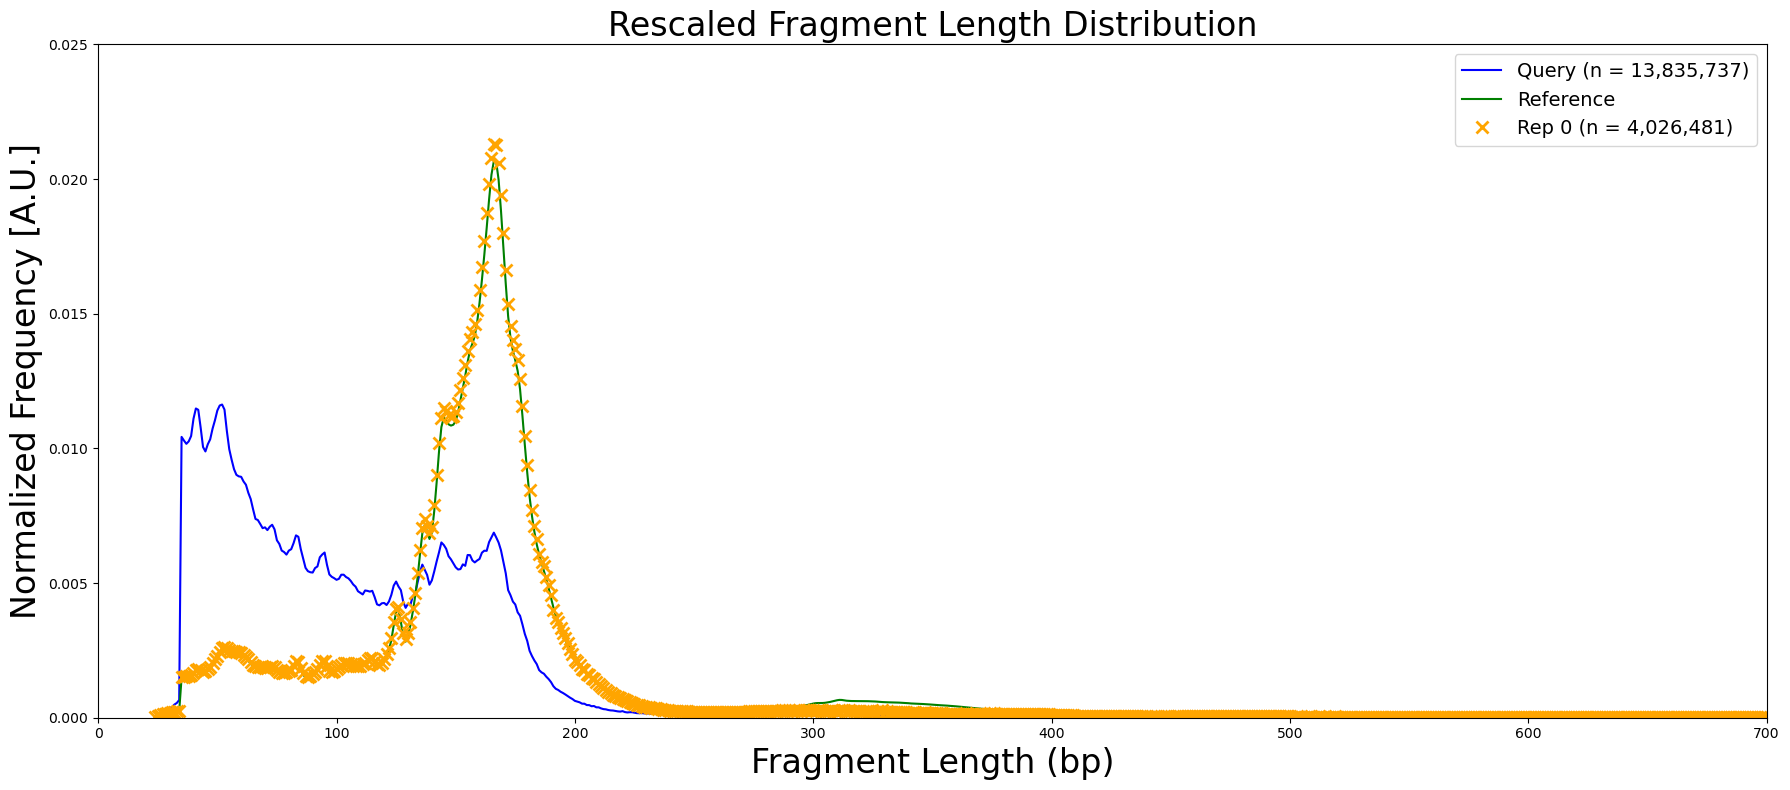

In [10]:
query_x, query_y = sorted_lengths, sorted_freqs
ref_x, ref_y = ref_lengths, ref_freqs
rescaled_x = sorted(rescaled_freq.keys())
rescaled_y = [rescaled_freq[k] for k in rescaled_x]

plt.figure(figsize=(18, 8))
plt.plot(query_x, query_y, label=f'Query (n = {total_fragments:,})', color='blue')
plt.plot(ref_x, ref_y, label='Reference', color='green')
plt.plot(rescaled_x, rescaled_y, 'x', label=f'Rep 0 (n = {total_rescaled:,})', color='orange', markersize=8, markeredgewidth=2)
plt.xlabel("Fragment Length (bp)", fontsize=24)
plt.ylabel("Normalized Frequency [A.U.]", fontsize=24)
plt.title("Rescaled Fragment Length Distribution", fontsize=24)
plt.xlim(0, 700)
plt.ylim(0, 0.025)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("./rescaled_prediction.png")
plt.show()

# Conclusion

- Computed and visualized fragment length distributions
- Successfully rescaled query distribution to match reference